In [27]:
import tensorflow as tf

from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from keras.applications.resnet_v2 import decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
import os

from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt


In [28]:
# Cargar el dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalizar los datos
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32')   / 255.

In [29]:

# Generar datos ruidosos
noise_factor = 0.10
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)



In [30]:
autoencoder_model = tf.keras.models.load_model('autoencoder-cifar10.h5')

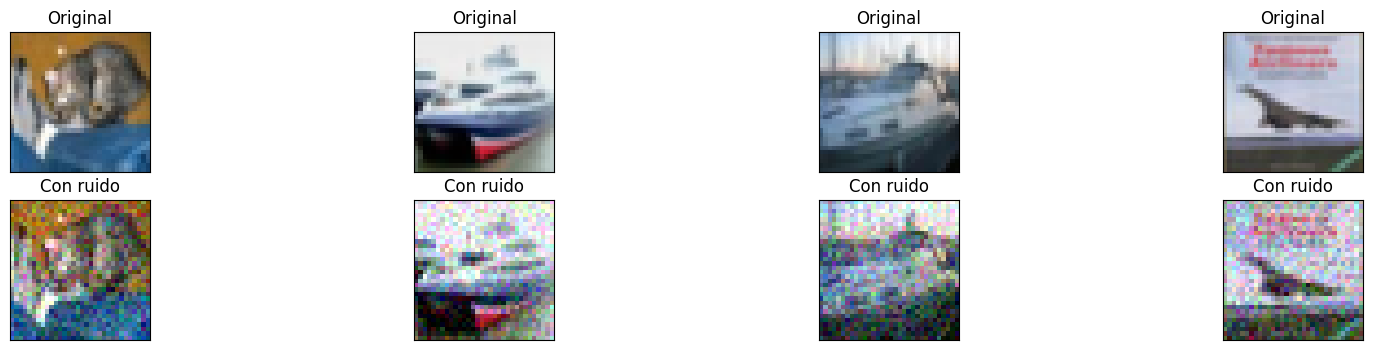

In [31]:

n = 4
plt.figure(figsize=(20, 4))

for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title('Original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen con ruido
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test_noisy[i])
    plt.title('Con ruido')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

1/1 [==============================] - 0s 17ms/step


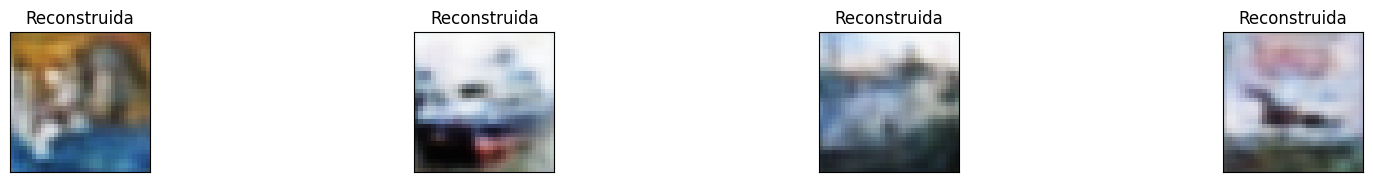

In [32]:
# Mostrar las imágenes reconstruidas
plt.figure(figsize=(20, 4))

for i in range(n):
    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1)
    reconstructed = autoencoder_model.predict(X_test_noisy[i].reshape(1, 32, 32, 3))
    plt.imshow(reconstructed.reshape(32, 32, 3))
    plt.title('Reconstruida')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [33]:
modelo = ResNet50V2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [34]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = modelo(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [35]:
img = image.image_utils.load_img(os.path.join('data','YellowLabradorLooking_new.jpg'), target_size=(224, 224))
img = image.image_utils.img_to_array(img)
resize = preprocess_input(np.expand_dims(img, axis=0))

image_probs = modelo.predict(resize)

1/1 [==============================] - 1s 674ms/step


In [36]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(208, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

resize_tensor = tf.convert_to_tensor(resize, dtype=tf.float32)

In [37]:
noise = create_adversarial_pattern(resize_tensor, label)

perturbated_img = resize + noise * 0.1
perturbated_img = tf.clip_by_value(perturbated_img, -1, 1)

prediction_noisy = modelo.predict(perturbated_img)

1/1 [==============================] - 0s 21ms/step


In [38]:
perturbated_img[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 0.12352946,  0.16274515, -0.35490194],
        [ 0.30784318,  0.3784314 , -0.11568626],
        [ 0.1941177 ,  0.28823534, -0.1980392 ],
        ...,
        [-0.04901955, -0.00980387, -0.44901958],
        [-0.04901955, -0.00980387, -0.44901958],
        [-0.05686269, -0.00980387, -0.28039214]],

       [[ 0.08431377,  0.1313726 , -0.3705882 ],
        [ 0.10784318,  0.17843142, -0.31568626],
        [ 0.1941177 ,  0.28823534, -0.1980392 ],
        ...,
        [ 0.2058824 ,  0.0686275 , -0.37843135],
        [ 0.15098044,  0.21372554, -0.2490196 ],
        [ 0.22156867,  0.28431377, -0.1862745 ]],

       [[ 0.22156867,  0.2921569 , -0.40196076],
        [ 0.05294123,  0.33921573, -0.37843135],
        [ 0.10784318,  0.20196083, -0.11568626],
        ...,
        [ 0.24509808,  0.32352945, -0.14705881],
        [ 0.27647063,  0.354902  , -0.1235294 ],
        [ 0.23725495,  0.31568632, -0.17843136]],

       ...,

     

In [39]:
# Divide the 224x224 image into 32x32 images
def divide_image(image):
    images = []
    for i in range(0, 224, 32):
        for j in range(0, 224, 32):
            images.append(image[i:i+32, j:j+32])
    return images

# Reconstruct the 224x224 image  from the 32x32 images
def reconstruct_image(images):
    image = np.zeros((224, 224, 3))
    k = 0
    for i in range(0, 224, 32):
        for j in range(0, 224, 32):
            image[i:i+32, j:j+32] = images[k]
            k += 1
    return image


In [40]:
# Divide the image into 32x32 images
images = divide_image(perturbated_img[0])

In [41]:
len(images)

49

In [42]:
images

[<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
 array([[[ 0.12352946,  0.16274515, -0.35490194],
         [ 0.30784318,  0.3784314 , -0.11568626],
         [ 0.1941177 ,  0.28823534, -0.1980392 ],
         ...,
         [ 0.16274515,  0.27254906, -0.20588234],
         [ 0.17058828,  0.2803922 , -0.18235293],
         [ 0.3784314 ,  0.4803922 ,  0.05686275]],
 
        [[ 0.08431377,  0.1313726 , -0.3705882 ],
         [ 0.10784318,  0.17843142, -0.31568626],
         [ 0.1941177 ,  0.28823534, -0.1980392 ],
         ...,
         [ 0.354902  ,  0.4647059 , -0.01372548],
         [ 0.39411768,  0.5039216 ,  0.0254902 ],
         [ 0.40980396,  0.51176476,  0.07254902]],
 
        [[ 0.22156867,  0.2921569 , -0.40196076],
         [ 0.05294123,  0.33921573, -0.37843135],
         [ 0.10784318,  0.20196083, -0.11568626],
         ...,
         [ 0.34705886,  0.45686278, -0.02156862],
         [ 0.3784314 ,  0.48823532,  0.00980393],
         [ 0.17843142,  0.28823534, -0.1745098 ]

In [43]:
images[0].shape

TensorShape([32, 32, 3])

In [44]:
len(images)

49

In [45]:

# Process each 32x32 image and store the results
reconstructed_images = []
for image_chunk in images:
    # Reshape for prediction using tf.reshape
    reshaped_image_chunk = tf.reshape(image_chunk, [1, 32, 32, 3])
    # Predict using the reshaped tensor
    reconstructed_img = autoencoder_model.predict(reshaped_image_chunk)
    # Append the output after removing the batch dimension
    reconstructed_images.append(reconstructed_img)
    
# Reconstruct the full image from processed parts
reconstructed_image = reconstruct_image(reconstructed_images)

# Assuming 'modelo' is your final prediction model and it expects the input shape (224, 224, 3)
prediction_reconstructed_image = modelo.predict(reconstructed_image.reshape(1, 224, 224, 3))


1/1 [==============================] - 0s 51ms/step


In [46]:
reconstructed_images

[array([[[[0.17707478, 0.15946448, 0.05004258],
          [0.1680958 , 0.1982759 , 0.02341624],
          [0.23401693, 0.27384964, 0.02582764],
          ...,
          [0.2890315 , 0.28648728, 0.02727105],
          [0.30444553, 0.2998476 , 0.04214283],
          [0.28219244, 0.28299144, 0.07165548]],
 
         [[0.09378691, 0.08599462, 0.01137299],
          [0.07964571, 0.09716663, 0.00467297],
          [0.14978236, 0.18064615, 0.00600271],
          ...,
          [0.31977868, 0.34957132, 0.01521756],
          [0.34726855, 0.3665519 , 0.02350302],
          [0.29995748, 0.28395796, 0.03655819]],
 
         [[0.08342461, 0.08989612, 0.00954724],
          [0.06123325, 0.08289059, 0.00294999],
          [0.11568074, 0.1571198 , 0.00348228],
          ...,
          [0.28303075, 0.35609046, 0.01081077],
          [0.29620898, 0.3361634 , 0.01519329],
          [0.3139838 , 0.29935527, 0.02880626]],
 
         ...,
 
         [[0.15360503, 0.13348602, 0.01310813],
          [0.12230

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


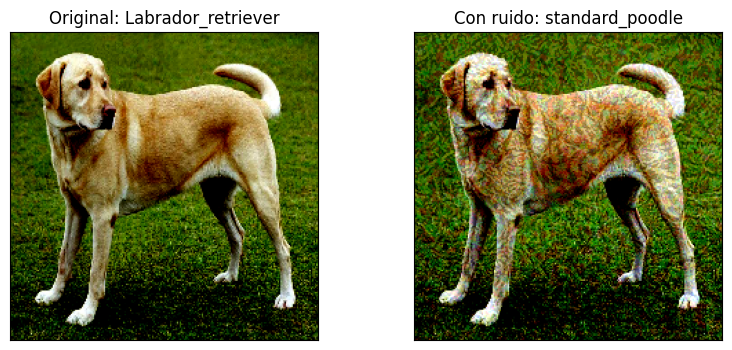

In [47]:

plt.figure(figsize=(20, 4))

# Imagen original
ax = plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original: ' + decode_predictions(image_probs, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Imagen con ruido
ax = plt.subplot(1, 4, 2)
plt.imshow(perturbated_img[0])
plt.title('Con ruido: ' + decode_predictions(prediction_noisy, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

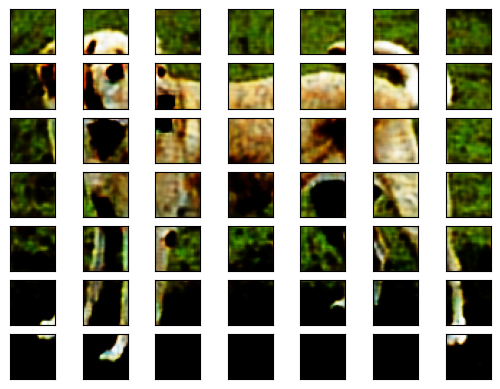

In [48]:
#Mostrar las 49 imágenes de 32x32
for i in range(len(reconstructed_images)):
    ax = plt.subplot(7, 7, i + 1)
    ixmg = reconstructed_images[i].reshape(32, 32, 3)

    plt.imshow(ixmg)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


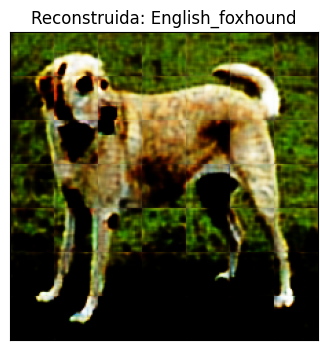

In [49]:
# Imagen reconstruida
plt.figure(figsize=(20, 4))

ax = plt.subplot(1, 4, 4)
plt.imshow(reconstructed_image)
plt.title('Reconstruida: ' + decode_predictions(prediction_reconstructed_image, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


Comparamos entre las distintas 

In [50]:

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(reconstructed_image, (3, 3), 5)

prediction_blurred_image = modelo.predict(blurred_image.reshape(1, 224, 224, 3))

1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


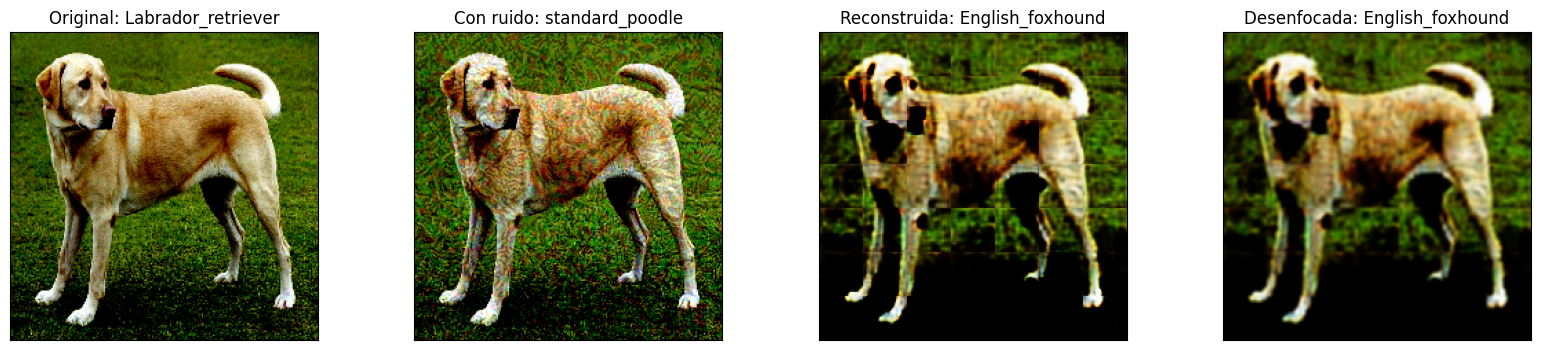

In [53]:
plt.figure(figsize=(20, 4))

# Imagen original
ax = plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original: ' + decode_predictions(image_probs, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Imagen con ruido
ax = plt.subplot(1, 4, 2)
plt.imshow(perturbated_img[0])
plt.title('Con ruido: ' + decode_predictions(prediction_noisy, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Imagen reconstruida
ax = plt.subplot(1, 4, 3)
plt.imshow(reconstructed_image)
plt.title('Reconstruida: ' + decode_predictions(prediction_reconstructed_image, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Imagen desenfocada
ax = plt.subplot(1, 4, 4)
plt.imshow(blurred_image)
plt.title('Desenfocada: ' + decode_predictions(prediction_blurred_image, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [52]:
print(decode_predictions(prediction_blurred_image,top=5))

[[('n02089973', 'English_foxhound', 0.7873341), ('n02089867', 'Walker_hound', 0.056603566), ('n02100236', 'German_short-haired_pointer', 0.03752339), ('n02088632', 'bluetick', 0.029936085), ('n02100735', 'English_setter', 0.016476952)]]
